# Snippets of code to get started on the AI Assignment 

This notebook contains some useful snippets of code to get you started with the assignment. The practical worksheets as well as the __[scikit-learn](https://scikit-learn.org/stable/)__ and __[keras](https://keras.io)__ webpages. 

## Code to load the data

This code presumes the supplied *eGeMAPS* folder is located in the same directory as this notebook

In [2]:
import numpy as np
import pandas as pd

Read the data in Pandas data frames and remove unecessary information

In [2]:
# Read in data as CSV, note the delimiter in these files is ;
Training_data = pd.read_csv("features/train.csv",sep=';')
Training_data = Training_data.drop(['name', 'frameTime'], axis=1)

Development_data = pd.read_csv("features/devel.csv",sep=';')
Development_data = Development_data.drop(['name', 'frameTime'], axis=1)

Test_data = pd.read_csv("features/test.csv",sep=';')
Test_data = Test_data.drop(['name', 'frameTime'], axis=1)

Convert the pandas dataframes to Numpy arrarys named `X_Train`, `X_Val` and `X_Test`

In [3]:
X_train = Training_data.values
X_devel = Development_data.values
X_test = Test_data.values

print(X_train.shape)
print(X_devel.shape)
print(X_test.shape)

(9505, 88)
(9596, 88)
(9551, 88)


## Code to read in labels and converts them to *single column* numpy arrary

This code presumes the supplied *Labels* folder is located in the same directory as this notebook

**Reminder** Labels are *not* provided for the test set

In [4]:
# Read in data as CSV, note the delimiter in these files is ;
Training_labels = pd.read_csv("labels/train.csv")
Training_labels = Training_labels.drop(['file_name'], axis=1)

Development_labels = pd.read_csv("labels/devel.csv")
Development_labels = Development_labels.drop(['file_name'], axis=1)

Code to produce a single column numpy arrays named `Y_Train`, `Y_Val`
 - **Note:** 0 denotes "cold" and 1 denotes "not cold"

In [5]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(['C', 'NC'])
y_train = le.transform(np.ravel(Training_labels))
y_devel = le.transform(np.ravel(Development_labels))

print(y_train.shape)
print(y_devel.shape)

(9505,)
(9596,)


## Example code for training a SVM with training  data and testing on development data

This block of code uses a min-max scaler to scale both the training and development data so all the values of all features is between 0 and 1

In [6]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_devel_scaled = min_max_scaler.transform(X_devel)

Train a linear SVM using the scaled training data. 
- **Note** There are no guarantees this is a suitable classifier set-up for the task

In [7]:
from sklearn.svm import SVC

svmClas_TR_1 = SVC(kernel='linear', C = 0.01, random_state=42) 
svmClas_TR_1.fit(X_train_scaled, y_train)

SVC(C=0.01, kernel='linear', random_state=42)

This block demostrates how to perform prediction on the (scaled) developement data and then score the performance using accuracy and plots the resulting confusion matrix
- **Note** There are no guarantees this is a suitable performance metric for this task

Classification of SVM: Accuracy 0.895


<AxesSubplot:>

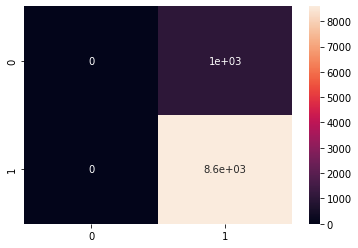

In [8]:
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred = svmClas_TR_1.predict(X_devel_scaled)

acc = accuracy_score(y_devel, y_pred)

print( "Classification of SVM: Accuracy " + str(round(acc,3)))

cf_matrix = confusion_matrix(y_devel, y_pred)
sns.heatmap(cf_matrix, annot=True)

## Example code for training a feedward (dense) neural network with the training data and testing on development data

import the required functions
- **Note** you may need to change these to suit your TensorFlow/Keras set-up

In [9]:
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt

2022-05-21 14:50:12.774474: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/changhyun/catkin_ws/devel/lib:/opt/ros/noetic/lib
2022-05-21 14:50:12.774499: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Our standard printing function to display loss and accuracy over the training epochs

In [10]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

Code to convert the training labels to one-hot vecotrs

In [11]:
y_train_vec = to_categorical(y_train, 2)
y_devel_vec = to_categorical(y_devel, 2)

Code to normalise the data so that the distribution of each feature of the data partitions has a mean of zeor and unit variance

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_devel_scaled = scaler.transform(X_devel)

Declare a new sequential keras model
- **Note** Again, there are no guarantees this is a suitable classifier set-up for the task

In [13]:
# define the keras model
def create_FF_model():
    model = Sequential()
    model.add(Dense(64, input_dim=n_features, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    print(model.summary())
    return model

Code to train the network on the scaled training data
- **Note** Again, there are no guarantees the parameters given below are suitable for the task

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                5696      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 5,826
Trainable params: 5,826
Non-trainable params: 0
_________________________________________________________________


2022-05-21 14:50:32.898208: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/changhyun/catkin_ws/devel/lib:/opt/ros/noetic/lib
2022-05-21 14:50:32.898241: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-21 14:50:32.898266: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (changhyun-X510UAR): /proc/driver/nvidia/version does not exist
2022-05-21 14:50:32.898521: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None


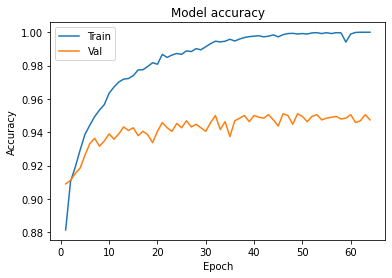

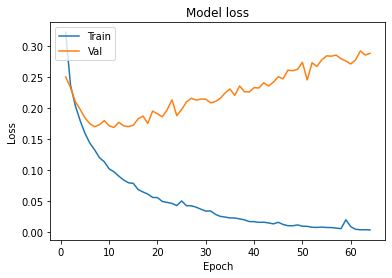

In [14]:
n_features = X_train_scaled.shape[1]

model_FF_TR_1 = create_FF_model()

model_FF_TR_1.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 64
BATCH_SIZE = 32

history = model_FF_TR_1.fit(
    X_train_scaled, y_train_vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=0
)
plot_learningCurve(history, EPOCHS)

Evaluate the performance of the model on the scaled development set data
- **Note** Again, there are no guarantees this is a suitable performance metric for this task

300/300 [==============================] - 0s 867us/step
Classification of Network: Accuracy 0.877


<AxesSubplot:>

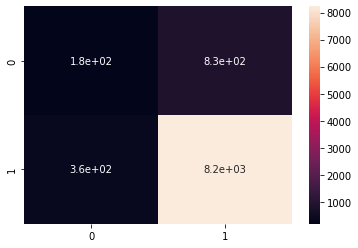

In [15]:
y_pred_vec = model_FF_TR_1.predict(X_devel_scaled)

# This line converts the softmax output back to a single column array
y_pred = np.argmax(y_pred_vec, axis=1)


acc = accuracy_score(y_devel, y_pred)

print( "Classification of Network: Accuracy " + str(round(acc,3)))

cf_matrix = confusion_matrix(y_devel, y_pred)
sns.heatmap(cf_matrix, annot=True)

## Combine training and developement data for final testing

In [16]:
# Combine the feature sets
X_tr_dv = np.concatenate((X_train, X_devel), axis=0)

#Combine the labels
y_tr_dv = np.concatenate((y_train, y_devel), axis=0)

## Example code for training a SVM with training and development data and generating the test samples for external validation

**Reminder** There are no guarantees this is a suitable classifier set-up for the task

In [17]:
# Scale the new combined feature space and test data
min_max_scaler = MinMaxScaler()
X_tr_dv_scaled = min_max_scaler.fit_transform(X_tr_dv)
X_test_scaled = min_max_scaler.transform(X_test)

#Train the classifier on the new combined scaled feature space
svmClas_CFV = SVC(kernel='linear', C = 0.01, random_state=42) 
svmClas_CFV.fit(X_tr_dv_scaled, y_tr_dv)

#Obtain test set prediction using the scaled data
y_test_pred = svmClas_CFV.predict(X_test_scaled)

Code to convert test prediction into a CSV file. The produced CSV will be in the same folder as this notebook
- Remember to adjust name and trial number to suit

In [18]:
le = preprocessing.LabelEncoder()
le.fit(['C', 'NC'])
Test_predictions = le.inverse_transform(np.ravel(y_test_pred))
Test_predictions = pd.DataFrame(Test_predictions)

Test_predictions.to_csv('Cummins_Trial_1.csv', index=False, na_rep='NaN') 

## Example code for training a feedward (dense) neural network with training and development data and generating the test samples for external validation

**Reminder** There are no guarantees this is a suitable classifier set-up for the task

In [19]:
# Scale the new combined feature space and test data
scaler = StandardScaler()
X_tr_dv_scaled = scaler.fit_transform(X_tr_dv)
X_test_scaled = scaler.transform(X_test)

# Convert the combined lables to one-hot vectors for softmax
y_tr_dv_vec = to_categorical(y_tr_dv, 2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                5696      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 5,826
Trainable params: 5,826
Non-trainable params: 0
_________________________________________________________________
None


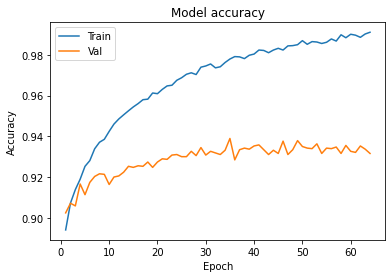

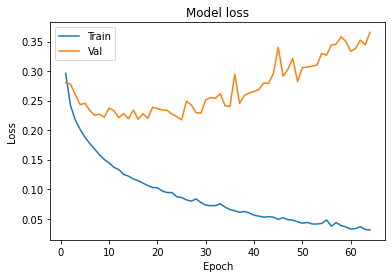

In [20]:
n_features = X_tr_dv_scaled.shape[1]

#As we are using the same model architecture, I have not created a new function call
model_FF_TRDV_1 = create_FF_model()

model_FF_TRDV_1.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 64
BATCH_SIZE = 32

history = model_FF_TRDV_1.fit(
    X_tr_dv_scaled, y_tr_dv_vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=0
)
plot_learningCurve(history, EPOCHS)

Obtain test set prediction using the scaled data and convert them back into a single colum vector

In [ ]:
y_test_pred_vec = model_FF_TRDV_1.predict(X_test_scaled)
y_test_pred = np.argmax(y_test_pred_vec, axis=1)

Code to convert test prediction into a CSV file. The produced CSV will be in the same folder as this notebook
- Remember to adjust name and trial number to suit

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(['C', 'NC'])
Test_predictions = le.inverse_transform(np.ravel(y_test_pred))
Test_predictions = pd.DataFrame(Test_predictions)

Test_predictions.to_csv('Cummins_Trial_2.csv', index=False, na_rep='NaN') 